In [1]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully un

In [ ]:
import os
import glob
import shutil
import random
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import kagglehub

In [1]:
# Download latest version
path = kagglehub.dataset_download("sudarshanvaidya/random-images-for-face-emotion-recognition")

print("Path to dataset files:", path)

# Define the destination directory
destination_dir = "/content/images/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the downloaded directory to the destination directory
# The downloaded path is likely a directory containing the dataset files (the emotion categories)
for emotion_category in os.listdir(path):
    source_category_dir = os.path.join(path, emotion_category)
    destination_category_dir = os.path.join(destination_dir, emotion_category)

    # Create the destination category directory if it doesn't exist
    os.makedirs(destination_category_dir, exist_ok=True)

    # Copy the contents (files) from the source category directory to the destination category directory
    if os.path.isdir(source_category_dir):
        for item in os.listdir(source_category_dir):
            source_item_path = os.path.join(source_category_dir, item)
            destination_item_path = os.path.join(destination_category_dir, item)
            shutil.copy2(source_item_path, destination_item_path)
    else:
         # If the item is not a directory, copy it directly to the destination_dir (though unlikely for this dataset)
         shutil.copy2(source_category_dir, destination_dir)


print(f"Dataset contents copied to {destination_dir}")

Path to dataset files: /kaggle/input/random-images-for-face-emotion-recognition
Dataset contents copied to /content/images/


In [3]:
path_dir = "/content/images/"
counts = Counter()
for emotion in os.listdir(path_dir):
    emotion_dir = os.path.join(path_dir, emotion)
    if os.path.isdir(emotion_dir):
        counts[emotion] = len([
            f for f in os.listdir(emotion_dir)
            if os.path.isfile(os.path.join(emotion_dir, f))
        ])
print(counts)

Counter({'happiness': 1406, 'anger': 890, 'surprise': 775, 'sadness': 746, 'fear': 570, 'neutrality': 524, 'disgust': 439, 'contempt': 208})


In [4]:
# Target jumlah gambar
target_count = 1406

# Augmentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3)
])

# Daftar semua kelas
classes = ["anger", "contempt", "disgust", "fear",
           "happiness", "neutrality", "sadness", "surprise"]

for cls in classes:
    cls_dir = os.path.join(path_dir, cls)
    files = os.listdir(cls_dir)
    n = len(files)
    i = 0
    while len(os.listdir(cls_dir)) < target_count:
        img_path = os.path.join(cls_dir, files[i % n])
        img = cv2.imread(img_path)
        if img is None:
            i += 1
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aug = augment(image=img)["image"]
        save_path = os.path.join(cls_dir, f"aug_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(aug, cv2.COLOR_RGB2BGR))
        i += 1

print("✅ Semua kelas telah diseimbangkan")

✅ Semua kelas telah diseimbangkan


In [5]:
path_dir = "/content/images/"
counts = Counter()
for emotion in os.listdir(path_dir):
    emotion_dir = os.path.join(path_dir, emotion)
    if os.path.isdir(emotion_dir):
        counts[emotion] = len([
            f for f in os.listdir(emotion_dir)
            if os.path.isfile(os.path.join(emotion_dir, f))
        ])
print(counts)

Counter({'neutrality': 1406, 'anger': 1406, 'surprise': 1406, 'fear': 1406, 'disgust': 1406, 'contempt': 1406, 'happiness': 1406, 'sadness': 1406})


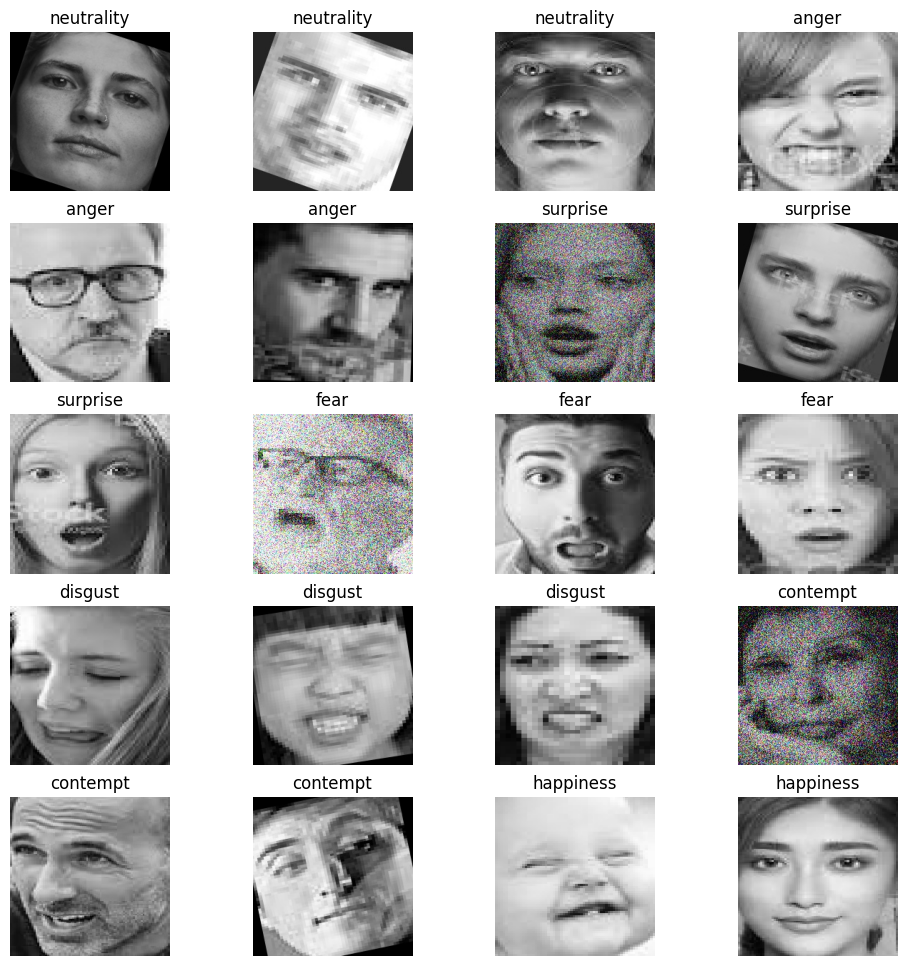

In [15]:
# ambil 20 sample pertama dari folder dataset
sample_dir = "/content/dataset_cls/train"  # sesuaikan path
classes = os.listdir(sample_dir)
images = []
labels = []

for cls in classes:
    cls_path = os.path.join(sample_dir, cls)
    for img_file in os.listdir(cls_path)[:3]:  # ambil 3 contoh per kelas
        img_path = os.path.join(cls_path, img_file)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(cls)

plt.figure(figsize=(12,12))
for i, (img, label) in enumerate(zip(images[:20], labels[:20])):
    plt.subplot(5,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(label)
plt.show()

In [6]:
# Path asal dataset (tiap folder = kelas)
path_dir = "/content/images"

# Daftar kelas
classes = sorted(os.listdir(path_dir))

# Statistik total
train_counts = {}
val_counts = {}

for cls in classes:
    cls_dir = os.path.join(path_dir, cls)

    # cari semua file gambar
    files = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        files.extend(glob.glob(os.path.join(cls_dir, ext)))

    print(f"[DEBUG] {cls} -> {len(files)} files ditemukan")

    random.shuffle(files)
    split = int(0.8 * len(files))
    train_files = files[:split]
    val_files = files[split:]

    train_counts[cls] = len(train_files)
    val_counts[cls] = len(val_files)

    # Simpan ke struktur YOLO classification
    for split_name, file_list in [("train", train_files), ("val", val_files)]:
        out_dir = f"dataset_cls/{split_name}/{cls}"
        os.makedirs(out_dir, exist_ok=True)
        for f in file_list:
            shutil.copy(f, os.path.join(out_dir, os.path.basename(f)))

# Print summary
print("✅ Konversi ke format YOLO classification selesai\n")
print("📊 Distribusi Data:")
for cls in classes:
    print(f" - {cls:10s} | Train: {train_counts[cls]} | Val: {val_counts[cls]} | Total: {train_counts[cls] + val_counts[cls]}")

[DEBUG] anger -> 1406 files ditemukan
[DEBUG] contempt -> 1406 files ditemukan
[DEBUG] disgust -> 1406 files ditemukan
[DEBUG] fear -> 1406 files ditemukan
[DEBUG] happiness -> 1406 files ditemukan
[DEBUG] neutrality -> 1406 files ditemukan
[DEBUG] sadness -> 1406 files ditemukan
[DEBUG] surprise -> 1406 files ditemukan
✅ Konversi ke format YOLO classification selesai

📊 Distribusi Data:
 - anger      | Train: 1124 | Val: 282 | Total: 1406
 - contempt   | Train: 1124 | Val: 282 | Total: 1406
 - disgust    | Train: 1124 | Val: 282 | Total: 1406
 - fear       | Train: 1124 | Val: 282 | Total: 1406
 - happiness  | Train: 1124 | Val: 282 | Total: 1406
 - neutrality | Train: 1124 | Val: 282 | Total: 1406
 - sadness    | Train: 1124 | Val: 282 | Total: 1406
 - surprise   | Train: 1124 | Val: 282 | Total: 1406


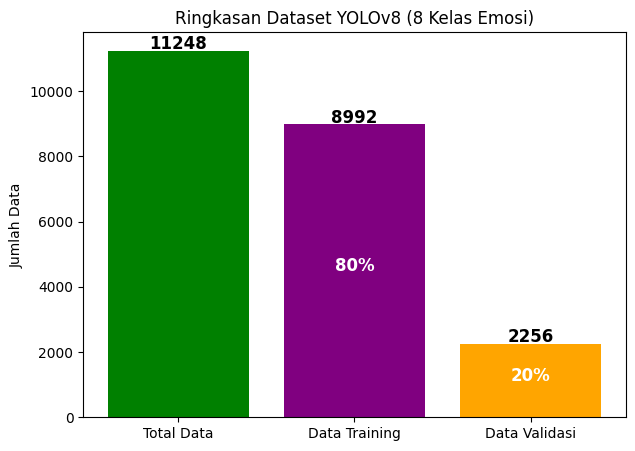

In [16]:
# Data hasil distribusi dataset
total_data = 11248   # total semua kelas
train_data = 8992    # 8 kelas x 1124
val_data   = 2256    # 8 kelas x 282

plt.figure(figsize=(7,5))
bars = plt.bar(
    ["Total Data", "Data Training", "Data Validasi"],
    [total_data, train_data, val_data],
    color=["green", "purple", "orange"]
)

# tambahkan nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, yval+50, str(yval),
             ha='center', fontsize=12, fontweight="bold")

# persentase di bar training/val
plt.text(1, train_data/2, "80%", ha="center", color="white", fontsize=12, fontweight="bold")
plt.text(2, val_data/2, "20%", ha="center", color="white", fontsize=12, fontweight="bold")

plt.ylabel("Jumlah Data")
plt.title("Ringkasan Dataset YOLOv8 (8 Kelas Emosi)")
plt.show()

In [ ]:
import yaml

# definisi dataset YOLO
data_yaml = {
    "train": "dataset_yolo/train/images",
    "val": "dataset_yolo/val/images",
    "nc": len(classes),
    "names": classes  # urut sesuai 'classes = sorted(os.listdir(path_dir))'
}

# simpan ke file dataset.yaml
with open("dataset.yaml", "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("✅ File dataset.yaml berhasil dibuat")

✅ File dataset.yaml berhasil dibuat


In [7]:
# 1. Load model YOLOv8 classification pretrained
model = YOLO("yolov8n-cls.pt")  # model untuk klasifikasi, bukan deteksi

# 2. Training
model.train(
    data="/content/dataset_cls",   # folder dataset dengan struktur klasifikasi
    epochs=50,
    imgsz=224,                     # default untuk klasifikasi
    batch=32,
    optimizer="Adam",
    lr0=1e-3,
    project="runs/emotion_cls",
    name="yolov8_emotion"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_cls, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_wi

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a935b880ce0>
curves: []
curves_results: []
fitness: 0.9029255211353302
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8182623982429504, 'metrics/accuracy_top5': 0.98758864402771, 'fitness': 0.9029255211353302}
save_dir: PosixPath('runs/emotion_cls/yolov8_emotion')
speed: {'preprocess': 0.07118912987630856, 'inference': 0.24424753014230202, 'loss': 0.00020501684394917604, 'postprocess': 0.0012764468088783275}
task: 'classify'
top1: 0.8182623982429504
top5: 0.98758864402771

Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,445,128 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset_cls/train... found 8992 images in 8 classes ✅ 
val: /content/dataset_cls/val... found 2256 images in 8 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 983.5±503.1 MB/s, size: 25.2 KB)
val: Scanning /content/dataset_cls/val... 2256 images, 0 corrupt: 100% ━━━━━━━━━━━━ 2256/2256 3389093.8it/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 71/71 13.4it/s 5.3s
                   all       0.82      0.988
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val7
📊 Evaluation Results:
Top-1 Accuracy : 0.8196
Top-5 Accuracy : 0.9876


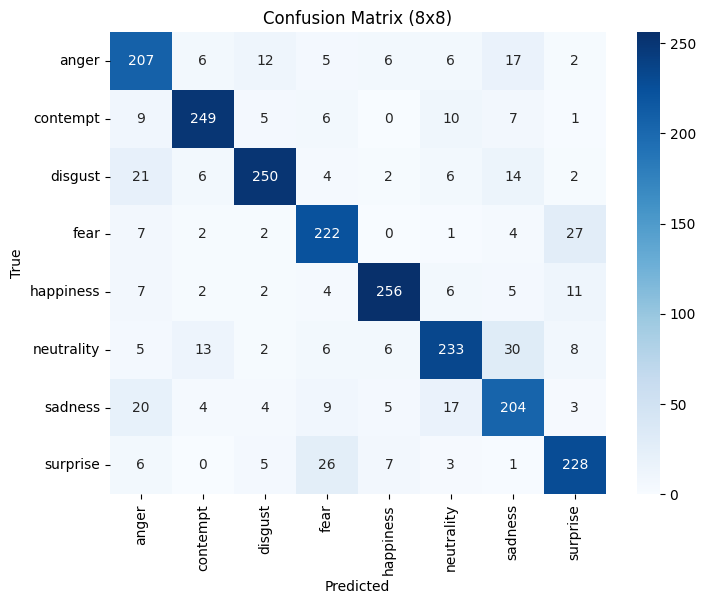

In [30]:
# 1. Load best model
model = YOLO("runs/emotion_cls/yolov8_emotion/weights/best.pt")

# 2. Evaluate
metrics = model.val(split='val', imgsz=224, batch=32)

# 3. Print metrics
print("📊 Evaluation Results:")
print(f"Top-1 Accuracy : {metrics.top1:.4f}")
print(f"Top-5 Accuracy : {metrics.top5:.4f}")

# 4. Ambil confusion matrix
cm = metrics.confusion_matrix.matrix
class_names = list(model.names.values())

true_num_classes = 8   # jumlah kelas seharusnya
cm = cm[:true_num_classes, :true_num_classes]
class_names = class_names[:true_num_classes]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.astype(int), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (8x8)")
plt.show()

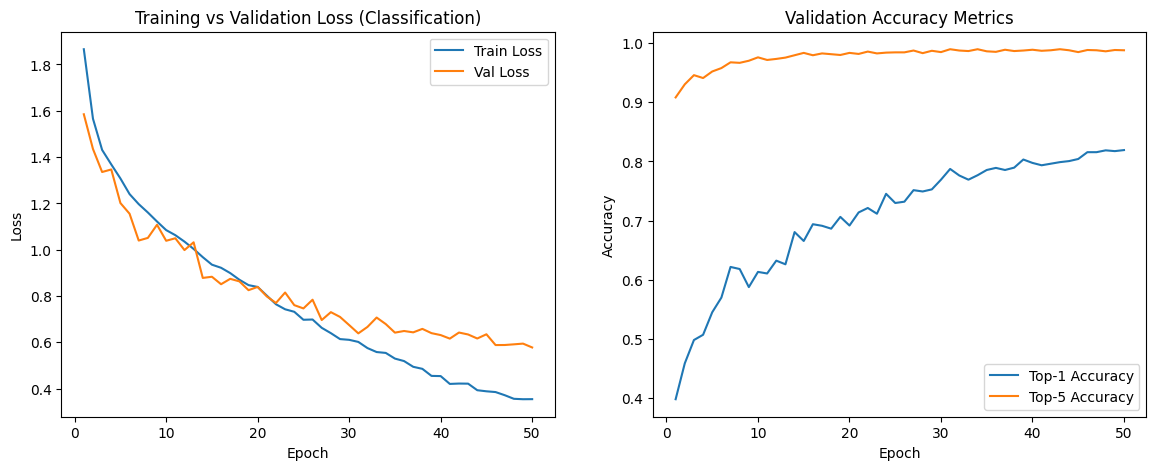

In [19]:
# load hasil training
results = pd.read_csv("/content/runs/emotion_cls/yolov8_emotion/results.csv")  # path ke results.csv

plt.figure(figsize=(14,5))

# Plot training vs validation loss
plt.subplot(1,2,1)
plt.plot(results["epoch"], results["train/loss"], label="Train Loss")
plt.plot(results["epoch"], results["val/loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Classification)")
plt.legend()

# Plot Top-1 & Top-5 accuracy
plt.subplot(1,2,2)
plt.plot(results["epoch"], results["metrics/accuracy_top1"], label="Top-1 Accuracy")
plt.plot(results["epoch"], results["metrics/accuracy_top5"], label="Top-5 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Metrics")
plt.legend()

plt.show()

📊 Testing per kelas (1 sample + tampilkan foto):
🖼️ aug_386.jpg | Asli: anger | Prediksi: anger (0.96)
🖼️ aug_276.jpg | Asli: contempt | Prediksi: contempt (0.65)
🖼️ aug_378.jpg | Asli: disgust | Prediksi: disgust (0.94)
🖼️ aug_692.jpg | Asli: fear | Prediksi: fear (1.00)
🖼️ images - 2020-11-06T202548.276_face.png | Asli: happiness | Prediksi: happiness (0.98)
🖼️ aug_841.jpg | Asli: neutrality | Prediksi: neutrality (0.71)
🖼️ aug_164.jpg | Asli: sadness | Prediksi: sadness (1.00)
🖼️ images - 2020-11-06T202924.536_face.png | Asli: surprise | Prediksi: surprise (0.94)


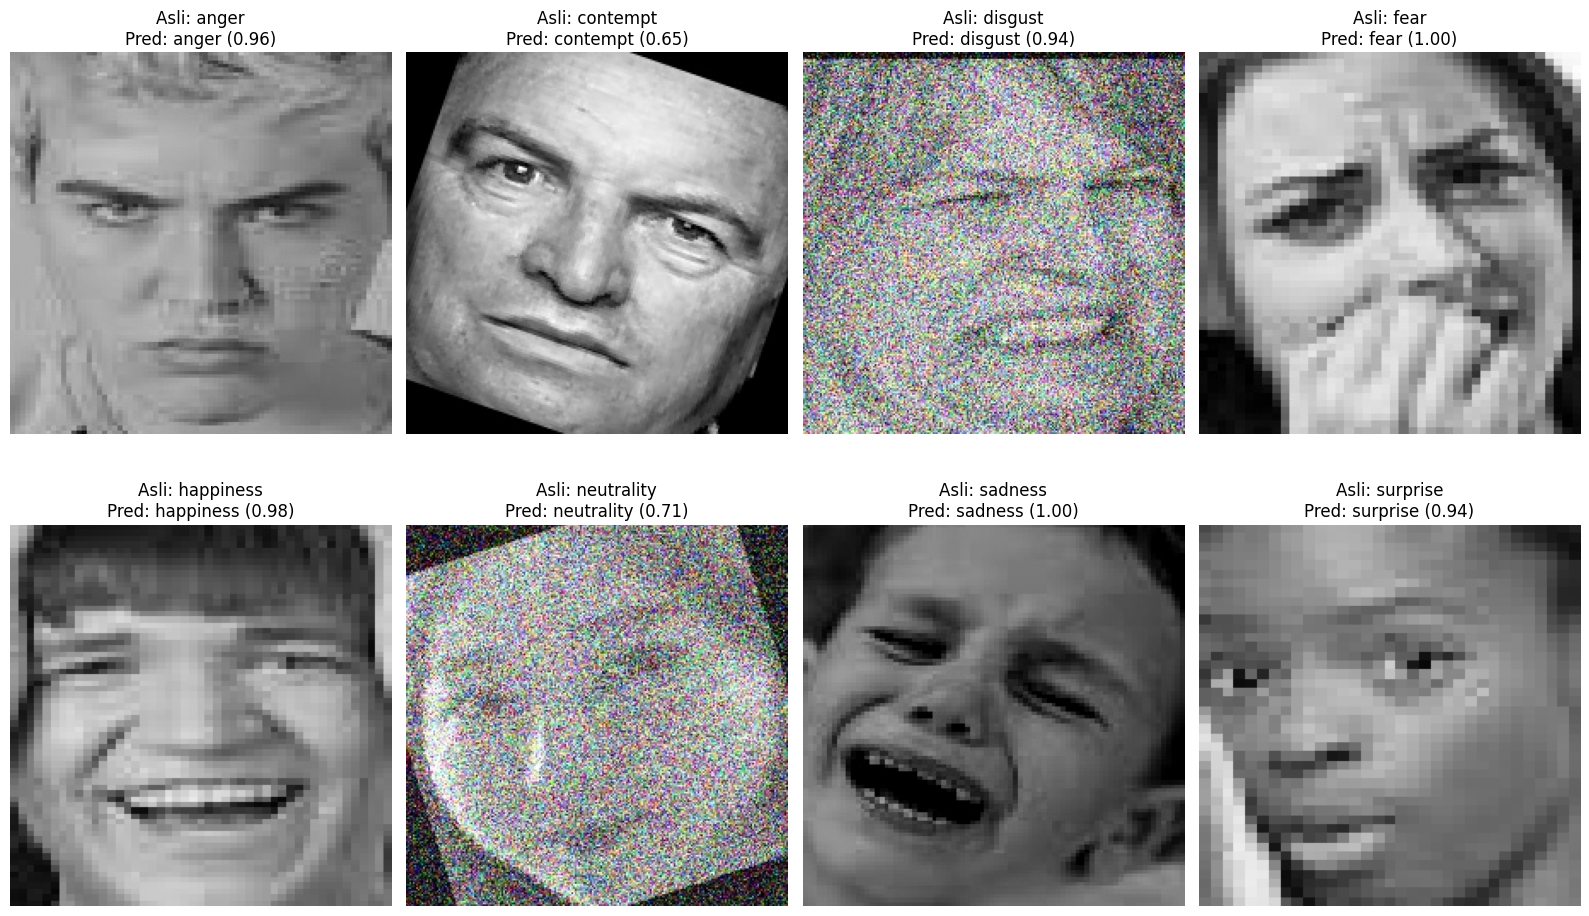

In [24]:
# Load best model
model = YOLO("/content/runs/emotion_cls/yolov8_emotion/weights/best.pt")

# Path folder val
val_dir = "/content/dataset_cls/val"

# Daftar kelas
classes = sorted(os.listdir(val_dir))

print("📊 Testing per kelas (1 sample + tampilkan foto):")
plt.figure(figsize=(16,10))

for i, cls in enumerate(classes):
    cls_path = os.path.join(val_dir, cls)
    img_file = random.choice([f for f in os.listdir(cls_path) if f.endswith(('.jpg','.png','.jpeg'))])
    img_path = os.path.join(cls_path, img_file)

    # Prediksi
    results = model.predict(img_path, imgsz=224, verbose=False)
    probs = results[0].probs
    pred_class = results[0].names[probs.top1]
    conf = probs.top1conf.item()

    print(f"🖼️ {img_file} | Asli: {cls} | Prediksi: {pred_class} ({conf:.2f})")

    # Tampilkan gambar
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)  # 8 kelas = 2 baris x 4 kolom
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Asli: {cls}\nPred: {pred_class} ({conf:.2f})")

plt.tight_layout()
plt.show()